<a href="https://colab.research.google.com/github/djun1127/UMDAOSC650/blob/main/Final_Project/Jupyter/AOSC650_proj_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AOSC 650 Project
This code process the roll tracking data acquired in Extended Reality and Flight Controls Lab.

### Libraries Import

In [ ]:
import pandas as pd
from tkinter import filedialog as fd
import os
import sys
import numpy as np
from scipy.stats import zscore
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr
import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import shap

### Configuration Files

In [ ]:
name_test_sequence_file = 'subjetcs_test_session.xlsx'

name_feature_descrition_folder = 'input_file_test'
name_feature_description_file = 'features_description.xlsx'

name_sq_folder = 'subjective_results'
badford_sq_file_name = 'bedford_results.xlsx'
threel_sq_file_name = 'three_levels_results.xlsx'

# saving normalized dataset
name_csv_file = 'normalized_faetures.csv'
name_csv_folder = 'figure/dataset'

In [ ]:
##### Working Folder #####
dataset_folder =  "C:\\Users\\Dogyu\\Downloads\\Dogyu_dataset\\Dogyu_dataset\\physiological_features_results"
subjects = os.listdir(dataset_folder)

In [ ]:
# Construct the new directory path one step back
dir_test_sequence_file = os.path.join(os.path.dirname(dataset_folder), name_test_sequence_file)
dir_bedford_sq = os.path.join(os.path.dirname(dataset_folder),name_sq_folder,badford_sq_file_name)
dir_threel_sq = os.path.join(os.path.dirname(dataset_folder),name_sq_folder,threel_sq_file_name)

# Print the new directory path
print("New directory path two steps back:", dir_test_sequence_file)

df_test_sequence_subjects = pd.read_excel(dir_test_sequence_file)

df_bedford = pd.read_excel(dir_bedford_sq)
df_threel = pd.read_excel(dir_threel_sq)

df_bedford.columns = df_bedford.columns.str.replace(' ','')
df_threel.columns = df_threel.columns.str.replace(' ','')

# Feature description file loading

dir_feature_description = os.path.join(os.path.dirname(dataset_folder),name_feature_descrition_folder,name_feature_description_file)
df_feature_descrition = pd.read_excel(dir_feature_description)

New directory path two steps back: C:\Users\Dogyu\Downloads\Dogyu_dataset\Dogyu_dataset\subjetcs_test_session.xlsx


In [ ]:
# Remove the item named 'OLD'
try:
    subjects.remove('OLD')
    print("'OLD' folder has been removed from the list.")
except ValueError:
    print("'OLD' folder was not found in the list.")

# Print the updated list
print("Updated list of folders:", subjects)

subjects_folder = [os.path.join(dataset_folder,subjects[x]) for x in range(len(subjects))]

'OLD' folder has been removed from the list.
Updated list of folders: ['Subject_1', 'Subject_10', 'Subject_11', 'Subject_12', 'Subject_13', 'Subject_14', 'Subject_15', 'Subject_2', 'Subject_3', 'Subject_4', 'Subject_5', 'Subject_6', 'Subject_7', 'Subject_8', 'Subject_9']


### Functions

In [ ]:
def rename_test_csv_name(name):
    # Haptic
    if 'Haptic' in name:
        name = name.replace('Haptic','H')
    # Audio
    if 'Audio' in name:
        name = name.replace('Audio','A')
    # Visual SVE
    if 'Visual' in name and 'SVE' in name:
        name = name.replace('_SVE','')
        name = name.replace('Visual','V')
    # Visual DVE
    if 'Visual' in name and 'DVE' in name:
        name = name.replace('_DVE','')
        name = name.replace('Visual','DVE')
    return name

def read_all_csv_files(directory):
    # List all files in the given directory
    files = os.listdir(directory)

    # Filter out only CSV files
    csv_files = [file for file in files if file.endswith('.csv')]

    # Read each CSV file into a pandas DataFrame and store them in a list
    subject_dataframe = pd.DataFrame()
    mean_subject_dataframe = pd.DataFrame()

    for csv_file in csv_files:
        file_path = os.path.join(directory, csv_file)
        df = pd.read_csv(file_path)

        # dataframe containing the mean of the trials generation
        mean_df = pd.DataFrame()
        if 'Baseline_' in csv_file:
            csv_file = csv_file.replace('Baseline_', '')
            mean_df = df[df['test_phase'] == 'baseline']

        column_names_except_last = df.columns[:-1]
        interested_columns = df.loc[df['test_phase'] != 'baseline', column_names_except_last]
        mean_values = interested_columns.mean()
        mean_values['test_phase'] = 'trials'
        mean_df = pd.concat([mean_df,mean_values.to_frame().T], ignore_index = True)

        # rename of the test csv file and assignement to a new column of the output datframe named 'test_name'
        csv_file = csv_file.replace('.csv', '')
        name_test = rename_test_csv_name(csv_file)
        # addinng of the column containing the name of the test
        df['test_name'] = name_test
        mean_df['test_name'] = name_test
        # generation of the overall datframes for the k-th subjects
        subject_dataframe = pd.concat([subject_dataframe, df], ignore_index = True)
        mean_subject_dataframe = pd.concat([mean_subject_dataframe, mean_df], ignore_index = True)

    return subject_dataframe, mean_subject_dataframe

### Reading of Subjects Files

In [ ]:
# initialization of the subjects dictionary
subjects_dict = {name: [] for name in subjects}
for k in range(len(subjects)):
    if k>=0:
        print(f"Subject under processing: {subjects[k]}")
        df, mean_df = read_all_csv_files(subjects_folder[k])

        flattened_list_one = []
        flattened_list_two = []

        # association of the test session to the respective day of execution and subject
        subjects_test_df = df_test_sequence_subjects[df_test_sequence_subjects['Subject'] == subjects[k]].dropna(axis=1)
        filtered_columns_one = subjects_test_df.filter(regex='^1\.?', axis=1).values.tolist()
        filtered_columns_two = subjects_test_df.filter(regex='^2\.?', axis=1).values.tolist()
        [flattened_list_one.extend(inner_list) for inner_list in filtered_columns_one]
        [flattened_list_two.extend(inner_list) for inner_list in filtered_columns_two]
        df.loc[df['test_name'].isin(flattened_list_one),'execution_day'] = 1
        df.loc[df['test_name'].isin(flattened_list_two),'execution_day'] = 2
        mean_df.loc[mean_df['test_name'].isin(flattened_list_one),'execution_day'] = 1
        mean_df.loc[mean_df['test_name'].isin(flattened_list_two),'execution_day'] = 2

        # check of nan elements
        if df['execution_day'].isna().any():
            print("Error: There are NaN values in 'execution_day'.")
            sys.exit(1)
        elif not df[~df['execution_day'].isin([1, 2])]['execution_day'].empty:
            print("Error: Elements different from 1 or 2")
            sys.exit(1)
        else:
            print("All elements are either 1 or 2.")
        # check of nan elements
        if mean_df['execution_day'].isna().any():
            print("Error: There are NaN values in 'execution_day'.")
            sys.exit(1)
        elif not mean_df[~mean_df['execution_day'].isin([1, 2])]['execution_day'].empty:
            print("Error: Elements different from 1 or 2")
            sys.exit(1)
        else:
            print("All elements are either 1 or 2.")

        subjects_dict[subjects[k]] = [df, mean_df]

Subject under processing: Subject_1
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_10


<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Dogyu\AppData\Local\Temp\ipykernel_41104\3787394116.py:13: SyntaxWarning: invalid escape sequence '\.'
  filtered_columns_one = subjects_test_df.filter(regex='^1\.?', axis=1).values.tolist()
C:\Users\Dogyu\AppData\Local\Temp\ipykernel_41104\3787394116.py:14: SyntaxWarning: invalid escape sequence '\.'
  filtered_columns_two = subjects_test_df.filter(regex='^2\.?', axis=1).values.tolist()


All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_11
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_12
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_13
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_14
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_15
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_2
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_3
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_4
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subject_5
All elements are either 1 or 2.
All elements are either 1 or 2.
Subject under processing: Subje

In [ ]:
name_features_to_drop = []#['mean_plf_respiration', 'std_plf_respiration','mean_phf_respiration', 'std_phf_respiration','mean_plf_phf_ratio_respiration', 'std_plf_phf_ratio_respiration']
name_features = df_feature_descrition['Feature']
name_features = [feature for feature in name_features if feature not in name_features_to_drop]

In [ ]:
# Outlier elimination function
def outlier_elimination(col):
    numeric_series = pd.to_numeric(col,errors='coerce')
    all_numeric = not numeric_series.isnull().any()
    if all_numeric:
        # outlier elimination
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        initial_count = len(col)
        col = col[(col >= lower_bound) & (col <= upper_bound)]
        final_count = len(col)
        if initial_count != final_count:
            print(f"Column: {col.name}, Outliers removed: {initial_count - final_count}")
        return col
    else:
        return col

# Baseline correction function
def percentile_baseline_correction(col, baseline_index):
    numeric_series = pd.to_numeric(col,errors='coerce')
    all_numeric = not numeric_series.isnull().any()
    if all_numeric:
        # baseline correction
        baseline_value = col.loc[baseline_index]
        if baseline_value != 0:
            col = (col - baseline_value) / baseline_value
        return col
    else:
        return col

def baseline_correction(df,day):
    # extraction of the rows correspoinding to the same execution day provided by the user
    day_df = df[df['execution_day'] == day]
    day_df_dropped = day_df.drop(columns=['execution_day'])
    # baseline index extraction
    baseline_index = day_df_dropped[day_df['test_phase'] == 'baseline'].index
    if baseline_index.shape[0] != 1:
        print(f'Error! Baseline evaluation error at day {day}')
        sys.exit(1)
    else:
        baseline_index = baseline_index[0]
    # baseline correction
    output_df = day_df_dropped.apply(lambda col: percentile_baseline_correction(col, baseline_index))

    return output_df

### Percentile Baseline Correction
The percentile baseline correction is applied to each feature for each subject taking into consideration the differences of the two difference baselines for each day.
The formula for percentile baseline correction is:

Corrected Value = (Original Value - Baseline Value) / Baseline Value

In [ ]:
dict_bc = {name: [] for name in subjects}
dict_bc_average = {name: [] for name in subjects}
# normalized_dict_mean = {name: [] for name in subjects}

for sub in subjects_dict.keys():

    # full trials normalization process
    df_subject = subjects_dict[sub][0]
    day_one_df_norm = baseline_correction(df_subject,1)
    day_two_df_norm = baseline_correction(df_subject,2)

    # data saving
    df_sub = pd.concat([day_one_df_norm,day_two_df_norm], ignore_index = True)

    df_sub.loc[df_sub['test_phase'] == 'baseline', 'test_name'] = 'B'
    baseline_rows = df_sub[df_sub['test_name'] == 'B']
    if len(baseline_rows) > 1:
        df_sub = df_sub.drop(baseline_rows.index[1:])
    df_sub = df_sub.reset_index(drop=True)

    # Check if there are nan in the dataframe
    if df_sub.isna().any().any():
        print("Error: There are NaN values in the dataframe.")
        sys.exit(1)

    # create a unified dataframe with all the subjects
    dict_bc[sub] = df_sub

# averaged dataframe generation
for sub in dict_bc.keys():
    dict_bc_average[sub] = dict_bc[sub].groupby('test_name')[name_features].median().reset_index()

In [ ]:
df_subject

,mean_bpm,std_bpm,median_bpm,pnn50,mean_ecg_plf,std_ecg_plf,mean_ecg_phf,std_ecg_phf,mean_ecg_plf_phf,std_ecg_plf_phf,...,peak_to_peak_fnirs_deoxy,slope_fnirs_deoxy,zero_crossing_fnirs_deoxy,polarity_fnirs_deoxy,entropy_fnirs_deoxy,auc_fnirs_deoxy,te_fnirs_deoxy,test_phase,test_name,execution_day
0,68.444903,2.523675,67.873390,0.000000,0.346141,0.075331,0.378117,0.051178,0.954312,0.333026,...,0.000000,8.950000e-06,0.008721,1.09880,2.72020,0.000079,9.020000e-08,trial1,A,1.0
1,68.376487,2.644709,68.532290,0.000000,0.235739,0.074543,0.281903,0.035776,0.826160,0.209219,...,0.000265,-5.790000e-07,0.007989,1.06810,3.37650,0.000407,1.690000e-06,trial2,A,1.0
2,70.605511,2.503899,70.422535,0.000000,0.325391,0.055221,0.287155,0.034439,1.167073,0.325328,...,0.000115,1.580000e-06,0.009321,1.13940,3.55350,0.000324,1.090000e-06,trial3,A,1.0
3,70.295703,2.416318,70.381256,0.000000,0.380645,0.051511,0.298744,0.045187,1.327261,0.364687,...,0.000183,-4.600000e-07,0.011984,0.99869,3.07820,0.000198,4.400000e-07,trial4,A,1.0
4,72.797883,1.786577,72.727273,0.000000,0.249646,0.045198,0.261154,0.025200,0.952444,0.129525,...,0.000077,5.130000e-07,0.003995,0.85808,3.35410,0.000095,1.440000e-07,trial5,A,1.0
5,66.705753,2.693165,66.371681,0.000000,0.324564,0.056180,0.288505,0.051695,1.164099,0.312178,...,0.000226,-6.565800e-07,0.011984,2.21590,3.53780,0.000089,1.141900e-07,trial1,A_H,1.0
6,69.369598,3.250449,69.284157,0.000000,0.347271,0.013851,0.307366,0.041493,1.149800,0.162808,...,0.000148,5.171900e-06,0.007989,1.15610,3.34790,0.000145,2.996000e-07,trial2,A_H,1.0
7,68.993081,3.896428,68.807339,0.014538,0.368189,0.027018,0.269755,0.028150,1.387703,0.236239,...,0.000225,4.407100e-07,0.009321,1.12040,3.53420,0.000089,1.140100e-07,trial3,A_H,1.0
8,69.122590,1.872237,68.886338,0.000000,0.292867,0.026623,0.317784,0.025108,0.921843,0.042697,...,0.000178,-3.187300e-07,0.007989,0.82204,3.39020,0.000086,1.183100e-07,trial4,A_H,1.0
9,67.759319,2.244019,67.720090,0.000000,0.291188,0.039270,0.276521,0.043891,1.057710,0.051413,...,0.000075,2.217900e-06,0.007989,1.19430,3.07410,0.000080,9.152000e-08,trial5,A_H,1.0


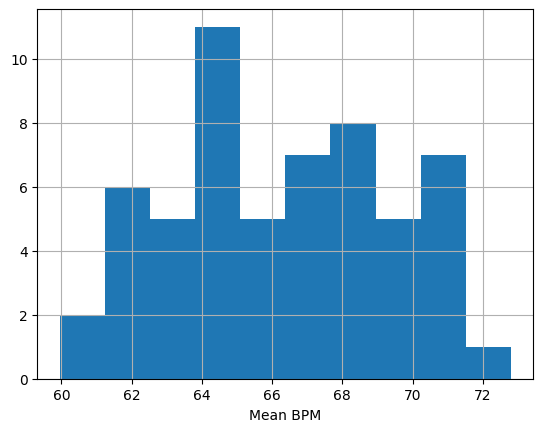

In [ ]:
df_subject['mean_bpm'].hist()
plt.xlabel('Mean BPM')
plt.show()

### Dataset standardization
Standardize per subject and feature in order to eliminate the differences of scales to prepare the floor to the multivariate analysis that will follow. There is not a std on modality or MWL because in that case the differnces among these characteriotics would be lost.

In [ ]:
dict_bc_std = {sub: pd.DataFrame(columns=dict_bc[sub].columns) for sub in dict_bc.keys()}
dict_bc_average_std = {sub: pd.DataFrame(columns=dict_bc[sub].columns) for sub in dict_bc.keys()}

for sub in dict_bc.keys():
    for name_feature in name_features:
        dict_bc_std[sub][name_feature] = zscore(dict_bc[sub][name_feature])
        dict_bc_std[sub]['test_name'] = dict_bc[sub]['test_name']
        dict_bc_std[sub]['test_phase'] = dict_bc[sub]['test_phase']
        dict_bc_std[sub]['subject'] = sub

        # averaged dataframe generation
        dict_bc_average_std[sub][name_feature] = zscore(dict_bc_average[sub][name_feature])
        dict_bc_average_std[sub]['test_name'] = dict_bc_average[sub]['test_name']
        dict_bc_average_std[sub]['subject'] = sub

Bedford Result Incorporation -->
The subjective MWL perceived during the trials assessed thorugh the Bedford Mental Workload is incorporated into the dataframe

In [ ]:
for sub in dict_bc_std.keys():
    n_subject = re.search(r'\d+', sub).group()
    for test_name in dict_bc_std[sub]['test_name'].unique():
        if test_name in df_bedford.columns:
            dict_bc_std[sub].loc[dict_bc_std[sub]['test_name'] == test_name,'bedford_score'] = df_bedford.loc[df_bedford['Subject'] == int(n_subject), test_name].values[0]
            dict_bc_average_std[sub].loc[dict_bc_average_std[sub]['test_name'] == test_name,'bedford_score'] = df_bedford.loc[df_bedford['Subject'] == int(n_subject), test_name].values[0]
        elif test_name == 'B':
            dict_bc_std[sub].loc[dict_bc_std[sub]['test_name'] == test_name,'bedford_score'] = 0
            dict_bc_average_std[sub].loc[dict_bc_average_std[sub]['test_name'] == test_name,'bedford_score'] = 0
        else:
            print(f"Error: Bedford score not found for {test_name}")
            sys.exit(1)

In [ ]:
dict_bc_std['Subject_15'][0:1]
df_ab = dict_bc_std['Subject_15'].loc[:, 'mean_bpm':'te_fnirs_deoxy']

df_bedford_arr = dict_bc_std['Subject_15'].loc[:, 'bedford_score']

# Assuming dict_bc_std contains DataFrames for each subject
subjects = [f'Subject_{i}' for i in range(1, 16)]  # List of subjects from 'Subject_1' to 'Subject_15'

# Combine concatenation and filtering in one step
df_all = pd.concat([
    dict_bc_std[subject].loc[
        dict_bc_std[subject]['test_phase'] != 'baseline',
        list(dict_bc_std[subject].loc[:, 'mean_bpm':'te_fnirs_deoxy'].columns) + ['bedford_score']
    ]
    for subject in subjects
])

# Split df_all into two DataFrames
df_features = df_all.loc[:, 'mean_bpm':'te_fnirs_deoxy']  # Columns from the first to 'te_fnirs_deoxy'
df_bedford_score = df_all.loc[:, ['bedford_score']]       # Only the 'bedford_score' column

### Dimensionality reduction
1. Remove highly correlated features (> 0.8)
2. Univariate feature selection

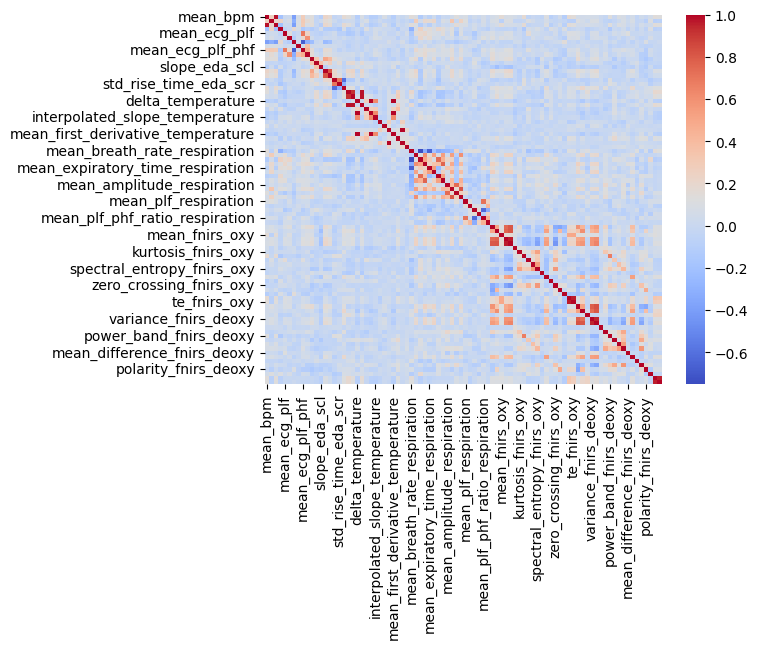

In [ ]:
# Calculate the correlation matrix
corr = df_features.corr()

# Create the heatmap
sns.heatmap(corr, cmap='coolwarm')
plt.show()

Remove highly correlated features (>0.8)

In [ ]:
corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X_uncorrelated = df_features.drop(columns=to_drop)

In [ ]:
X_uncorrelated.shape

(825, 76)

Univariate feature selection

In [ ]:
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X_uncorrelated, df_bedford_score.to_numpy().ravel())
selected_features = X_uncorrelated.columns[selector.get_support()]

In [ ]:
df_features_new = df_features[selected_features]

In [ ]:
df_features_new.shape

(825, 10)

Final correlation check

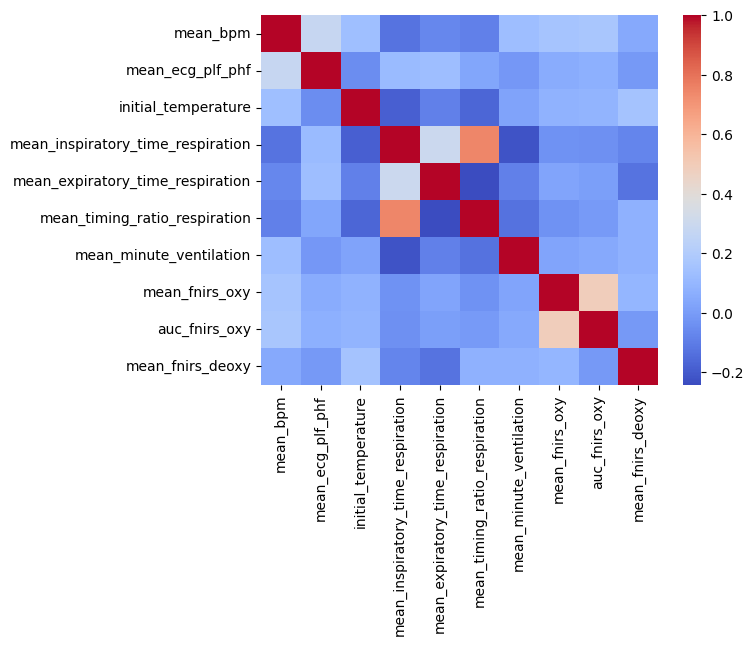

In [ ]:
# Calculate the correlation matrix
corr = df_features_new.corr()

# Create the heatmap
sns.heatmap(corr, #annot=True,
            cmap='coolwarm')
plt.show()

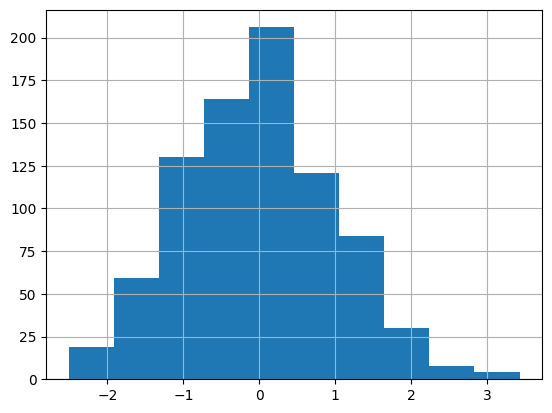

In [ ]:
df_features_new
df_features_new[selected_features[0]].hist(); plt.show()

Reset index

In [ ]:
df_features_new.index = range(0, len(df_features_new))
df_bedford_score.index = range(0, len(df_bedford_score))

Bedford scale: convert double to integer

In [ ]:
df_bedford_score_encoded = df_bedford_score.astype(int).values

### Clustering

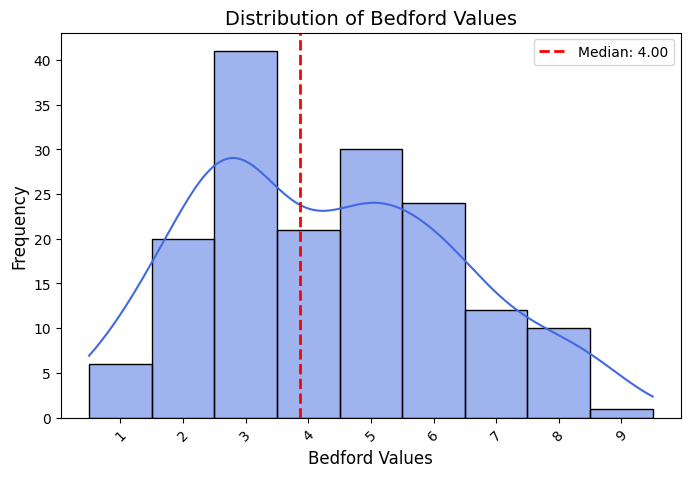

Number of elements less than 4.0: 88
Number of elements major than 4.0: 77


In [ ]:
bed_values = df_bedford.drop(columns=["Subject"]).values.flatten()

# Compute unique values count
n_unique_values = len(np.unique(bed_values))

# Compute the median (50th percentile) of bed_values
value_to_check = np.percentile(bed_values, 50)

# Compute bin edges for correct tick placement
bin_edges = np.histogram_bin_edges(bed_values, bins=n_unique_values)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute the center of each bin

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.histplot(bed_values, bins=n_unique_values, kde=True, color="royalblue")

# Add a vertical line at value_to_check
plt.axvline(value_to_check, color="red", linestyle="dashed", linewidth=2, label=f"Median: {value_to_check:.2f}")

# Set x-ticks to be at the center of bins
plt.xticks(bin_centers, labels=range(1, n_unique_values + 1), rotation=45)

# Labels and title
plt.xlabel("Bedford Values", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Bedford Values", fontsize=14)

# Add legend
plt.legend()

# Show plot
plt.show()

count_less_than_value = np.sum(bed_values <=  value_to_check)
count_maj_than_value = np.sum(bed_values >  value_to_check)
print(f"Number of elements less than {value_to_check}: {count_less_than_value}")
print(f"Number of elements major than {value_to_check}: {count_maj_than_value}")

In [ ]:
label_train_scaled = xr.where(df_bedford_score_encoded > 4, 1, 0)

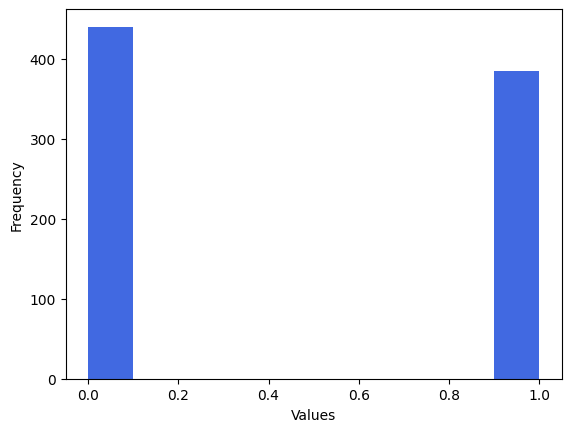

In [ ]:
plt.hist(label_train_scaled, color="royalblue")  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

### Split data set
Random split

In [ ]:
def random_split(data, label, split, seed=0):
    """
    Help spliting data randomly for training and testing.
    """
    np.random.seed(0)
    da_indx = np.random.permutation(data.shape[0])
    print(data.shape[0])
    data  = data.iloc[da_indx, :]
    label = label[da_indx, :]
    init_range = int(data.shape[0] * (1 - split))
    return data[:init_range], label[:init_range], data[init_range:], label[init_range:]


def random_split_single(data, label, split=0.3, seed=0):
    """
    Help spliting data randomly for training and testing.
    """
    np.random.seed(0)
    da_indx = np.random.permutation(data.shape[0])
    print(data.shape[0])
    data  = data.iloc[da_indx]
    label = label.iloc[da_indx]
    init_range = int(data.shape[0] * (1 - 0.3))
    return data[:init_range], label[:init_range], data[init_range:], label[init_range:]


In [ ]:
train_feats, train_label, test_feats, test_label = random_split(df_features_new, label_train_scaled, 0.3)

825


# ANN

In [ ]:
model = keras.Sequential() # instantiate model object

In [ ]:
model.add(keras.Input(shape=(10,), name="input_layer"))

In [ ]:
model.add(
    keras.layers.Dense(units=64, activation=keras.activations.relu))
model.add(
    keras.layers.Dropout(0.4))
model.add(
    keras.layers.Dense(units=32, activation=keras.activations.relu))
model.add(
   keras.layers.Dropout(0.4))
# model.add(
#    keras.layers.Dense(units=32, activation=keras.activations.relu))
# model.add(
#    keras.layers.Dropout(0.3))

In [ ]:
model.add(keras.layers.Dense(units=1, activation=keras.activations.sigmoid))

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x=train_feats,
    y=train_label,
    batch_size=64,
    epochs=100,
    verbose='auto',
    validation_split=0.2,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5127 - loss: 0.7029 - val_accuracy: 0.6379 - val_loss: 0.6683
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5626 - loss: 0.6770 - val_accuracy: 0.6466 - val_loss: 0.6650
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5349 - loss: 0.6897 - val_accuracy: 0.6466 - val_loss: 0.6635
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5490 - loss: 0.6850 - val_accuracy: 0.6293 - val_loss: 0.6623
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5600 - loss: 0.6806 - val_accuracy: 0.6293 - val_loss: 0.6590
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5539 - loss: 0.6721 - val_accuracy: 0.6379 - val_loss: 0.6568
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5312 - loss: 0.6788 - val_accuracy: 0.6552 - val_loss: 0.6556
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5926 - loss: 0.6601 - val_accuracy: 0.6379 - val_loss:

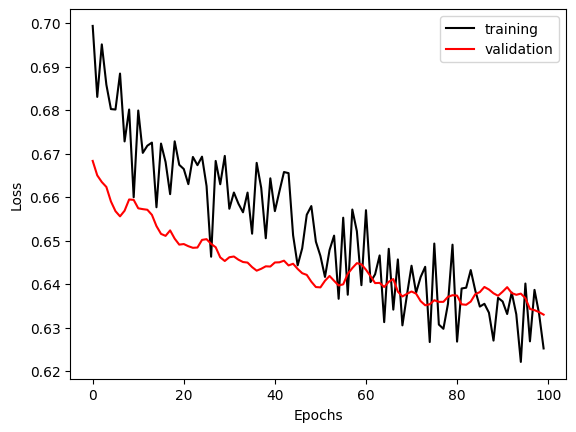

In [ ]:
plt.plot(range(0,100), history.history['loss'], c='k', label='training')
plt.plot(range(0,100), history.history['val_loss'], c='r', label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

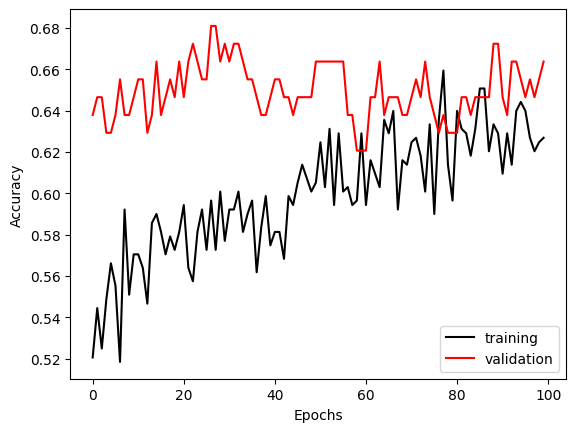

In [ ]:
plt.plot(range(0,100), history.history['accuracy'], c='k', label='training')
plt.plot(range(0,100), history.history['val_accuracy'], c='r', label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test

In [ ]:
test_feats

,mean_bpm,mean_ecg_plf_phf,initial_temperature,mean_inspiratory_time_respiration,mean_expiratory_time_respiration,mean_timing_ratio_respiration,mean_minute_ventilation,mean_fnirs_oxy,auc_fnirs_oxy,mean_fnirs_deoxy
114,1.705779,0.090799,1.412190,-1.463818,-1.274453,-0.946103,1.385716,1.152270,1.338464,1.870906
508,1.663152,0.622373,-0.502907,-0.986171,-1.445232,0.136100,-2.762441,-0.340510,-0.470241,-0.304297
666,-0.065786,0.331310,2.536779,3.207972,1.250488,2.177023,0.092701,-0.375119,-0.338521,-0.521575
799,2.323458,2.292941,1.488631,0.973640,1.036438,0.133678,-0.079101,1.586767,0.019007,1.668531
176,-0.940398,-0.274515,0.537605,-0.933325,-1.295276,-0.537515,1.315611,-0.541635,-0.356719,-0.436742
...,...,...,...,...,...,...,...,...,...,...
763,1.284206,0.459695,-1.885864,0.750875,0.218138,0.892164,1.112267,-1.221773,0.902330,-0.569898
192,-0.586199,0.776506,0.356521,0.292863,0.885291,-0.041516,-0.730449,0.634845,0.310212,1.239096
629,1.594318,0.842299,-0.345445,-0.278753,-1.527677,0.510492,0.755317,0.700119,0.656373,-1.649654
559,1.629380,0.045886,1.959327,-0.219247,-0.389483,0.349559,-0.047406,2.427221,2.005695,1.232019


In [ ]:
# to predict, use predict call
predictions = model.predict(test_feats)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
print(predictions.shape)

(248, 1)


In [ ]:
predictions_cat = xr.where(predictions > 0.5, 1, 0)
test_label_cat = xr.where(test_label > 4, 1, 0)

In [ ]:
print(classification_report(test_label, predictions_cat))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       120
           1       0.66      0.59      0.62       128

    accuracy                           0.63       248
   macro avg       0.63      0.63      0.63       248
weighted avg       0.63      0.63      0.63       248



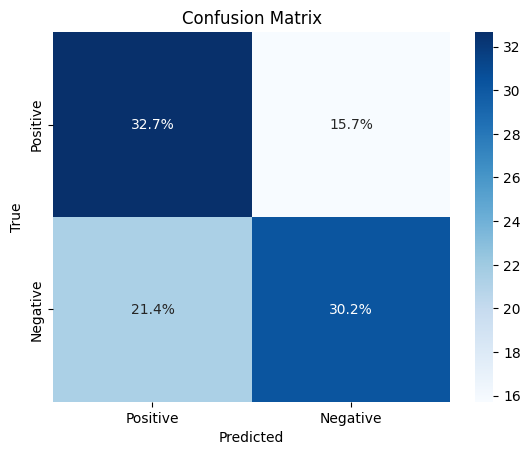

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_label, predictions_cat)

# Convert to percentage
conf_matrix_percent = conf_matrix / conf_matrix.sum() * 100

# Define labels
labels = ['Positive', 'Negative']

# Create custom annotations with '%' sign
annotations = np.array([["{:.1f}%".format(value) for value in row] for row in conf_matrix_percent])

# Plot heatmap
sns.heatmap(conf_matrix_percent, annot=annotations, fmt='', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Try K-fold validation


🔁 Fold 1/3
X_train shape: (550, 10), y_train shape: (550, 1)
X_val shape: (275, 10), y_val shape: (275, 1)
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5106 - loss: 0.7193 - val_accuracy: 0.4818 - val_loss: 0.6982
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4770 - loss: 0.7016 - val_accuracy: 0.4545 - val_loss: 0.6975
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5485 - loss: 0.6962 - val_accuracy: 0.4636 - val_loss: 0.6973
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5346 - loss: 0.6900 - val_accuracy: 0.4818 - val_loss: 0.6963
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5856 - loss: 0.6700 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5592 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6029 - loss: 0.6717 - val_accuracy: 0.5182 - val_loss: 0.6951
Epoch 8/10

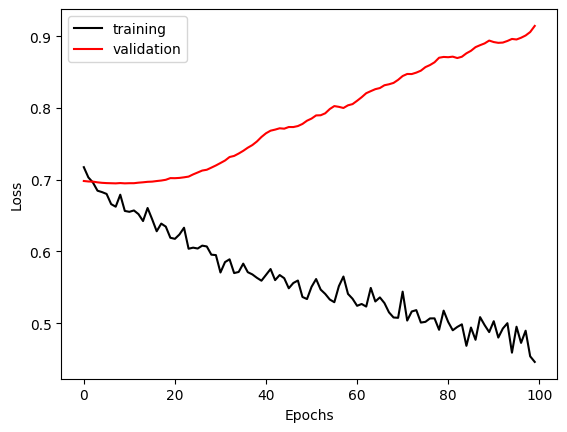

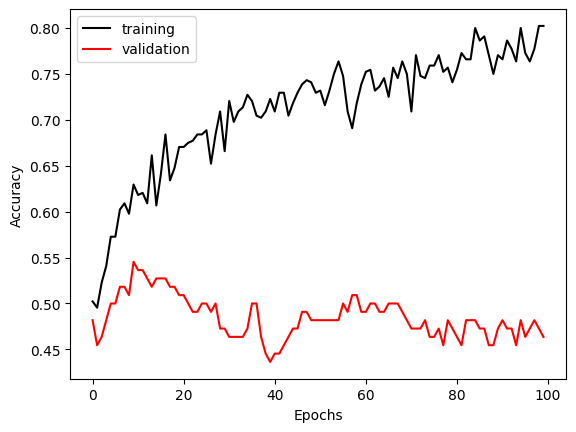

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 1 accuracy: 0.6364

🔁 Fold 2/3
X_train shape: (550, 10), y_train shape: (550, 1)
X_val shape: (275, 10), y_val shape: (275, 1)
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5140 - loss: 0.7217 - val_accuracy: 0.5273 - val_loss: 0.6781
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5405 - loss: 0.7088 - val_accuracy: 0.5455 - val_loss: 0.6765
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5246 - loss: 0.6918 - val_accuracy: 0.5818 - val_loss: 0.6749
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5757 - loss: 0.6777 - val_accuracy: 0.6273 - val_loss: 0.6747
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5872 - loss: 0.6887 - val_accuracy: 0.6636 - val_loss: 0.6749
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6005 - loss: 0.6684 - val_accuracy: 0.6455 - val_loss: 0.6752
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5555 - los

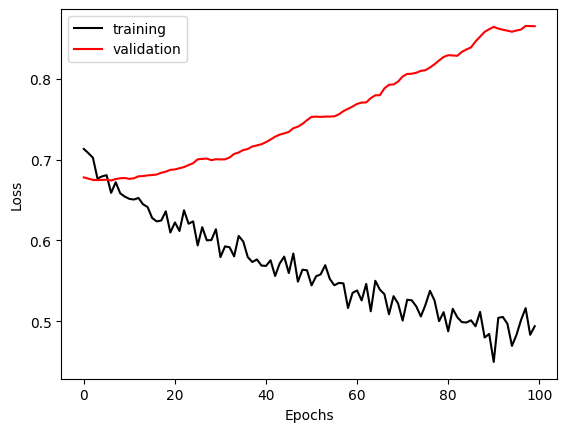

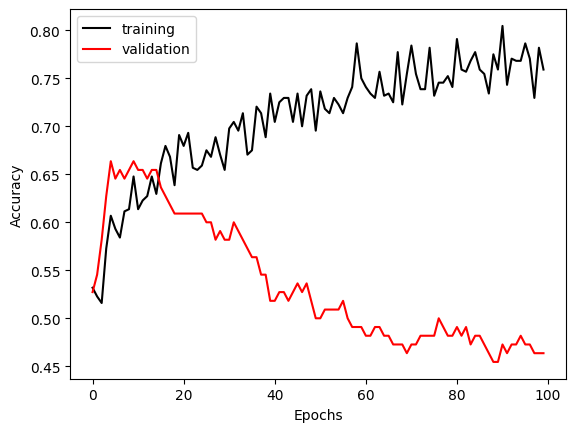

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 2 accuracy: 0.6655

🔁 Fold 3/3
X_train shape: (550, 10), y_train shape: (550, 1)
X_val shape: (275, 10), y_val shape: (275, 1)
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5344 - loss: 0.7160 - val_accuracy: 0.5727 - val_loss: 0.6658
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5133 - loss: 0.6931 - val_accuracy: 0.6182 - val_loss: 0.6635
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4886 - loss: 0.7165 - val_accuracy: 0.6000 - val_loss: 0.6675
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5472 - loss: 0.7034 - val_accuracy: 0.5909 - val_loss: 0.6698
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5393 - loss: 0.6919 - val_accuracy: 0.5636 - val_loss: 0.6747
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6349 - loss: 0.6662 - val_accuracy: 0.5545 - val_loss: 0.6789
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5736 - los

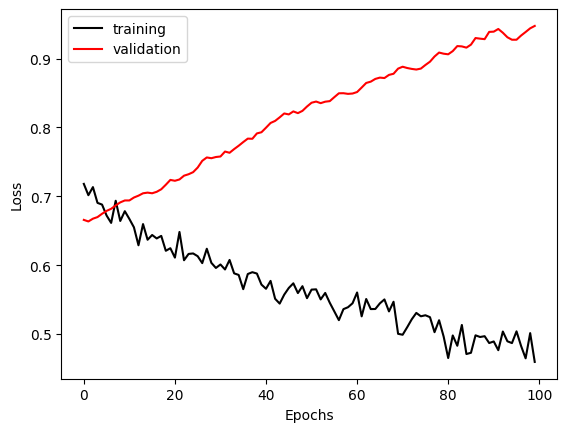

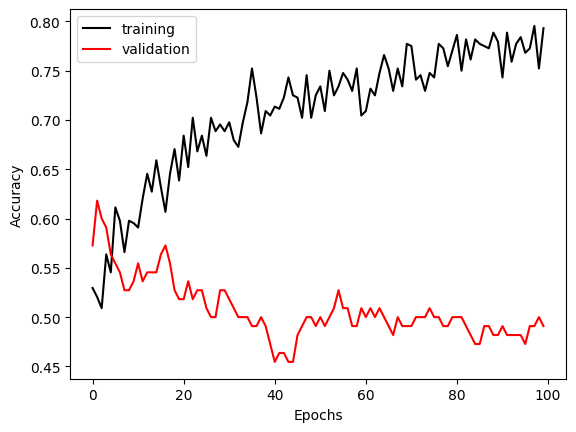

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 3 accuracy: 0.7236

📊 Average accuracy across 3 folds: 0.6752


In [ ]:
k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df_features_new, label_train_scaled)):
    print(f"\n Fold {fold+1}/{k}")

    X_train, X_val = df_features_new.iloc[train_idx], df_features_new.iloc[val_idx]
    y_train, y_val = label_train_scaled[train_idx], label_train_scaled[val_idx]

    print( f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print( f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    model = keras.Sequential() # instantiate model object
    model.add(keras.Input(shape=(10,), name="input_layer"))
    model.add(
        keras.layers.Dense(units=64, activation=keras.activations.relu))
    model.add(
        keras.layers.Dropout(0.3))
    model.add(
        keras.layers.Dense(units=32, activation=keras.activations.relu))
    model.add(
        keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(units=1, activation=keras.activations.sigmoid))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

    # Train
    history = model.fit(X_train, y_train,
                        batch_size=64,
                        epochs=100,
                        verbose='auto',
                        validation_split=0.2,
                        validation_data=None,
                        shuffle=True,
                        class_weight=None,
                        sample_weight=None,
                        initial_epoch=0,)

    plt.plot(range(0,100), history.history['loss'], c='k', label='training')
    plt.plot(range(0,100), history.history['val_loss'], c='r', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(range(0,100), history.history['accuracy'], c='k', label='training')
    plt.plot(range(0,100), history.history['val_accuracy'], c='r', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Predict
    y_pred = model.predict(X_val)
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Evaluate
    acc = accuracy_score(y_val, y_pred_labels)
    print(f"Fold {fold+1} accuracy: {acc:.4f}")
    accuracies.append(acc)

print(f"\n Average accuracy across {k} folds: {np.mean(accuracies):.4f}")

### XAI Analysis

c:\Users\Dogyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ExactExplainer explainer: 249it [00:26,  9.31it/s]                         
C:\Users\Dogyu\AppData\Local\Temp\ipykernel_41104\2144569169.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, test_feats, feature_names=feature_names)


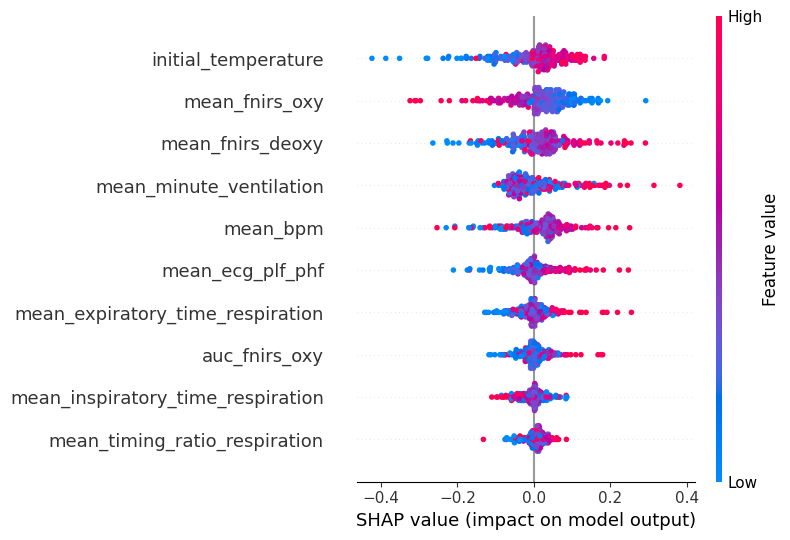

In [ ]:
#X ai analysis

#SHAP
X100 = shap.utils.sample(train_feats, 100)  # 100 instances for use as the background distribution

explainer = shap.Explainer(model, X100)
shap_vals = explainer(test_feats)


feature_names = test_feats.columns
# Create a SHAP beeswarm plot, colored by feature values when they are provided.
shap.summary_plot(shap_vals, test_feats, feature_names=feature_names)

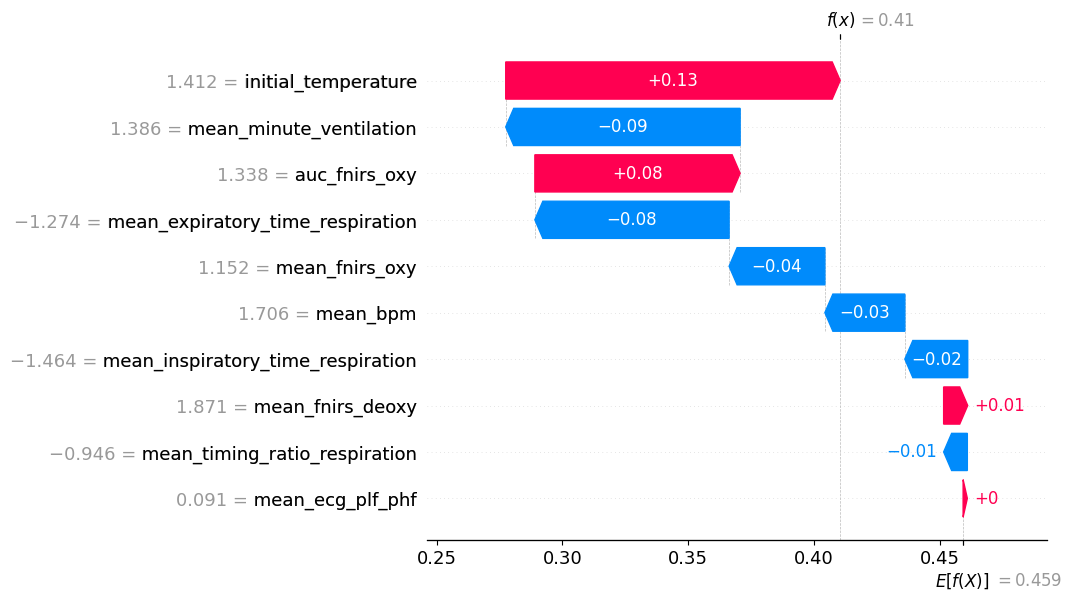

In [ ]:
sample_ind = 0
shap.plots.waterfall(shap_vals[sample_ind], max_display=14)